In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy


In [2]:
df = pd.read_csv('data/health.csv')
display(df.head())

,systolic,weight,height,bmi,waist,age,diabetes,smoker,fastfood
0,100,98.6,172.0,33.3,120.4,43,0,1,5
1,112,96.9,186.0,28.0,107.8,57,0,0,0
2,134,108.2,154.4,45.4,120.3,38,0,1,2
3,108,84.8,168.9,29.7,109.0,75,0,0,1
4,128,97.0,175.3,31.6,111.1,42,0,1,1


In [ ]:
numeric_cols = ['systolic', 'weight', 'height', 'bmi', 'waist', 'age', 'fastfood']
boolean_cols = ['diabetes', 'smoker']
all_cols = numeric_cols + boolean_cols

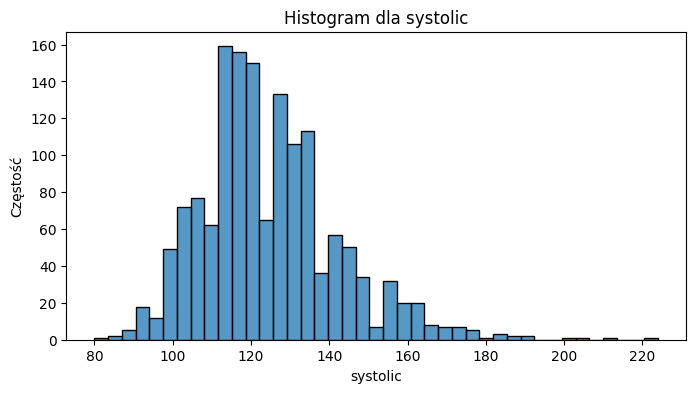

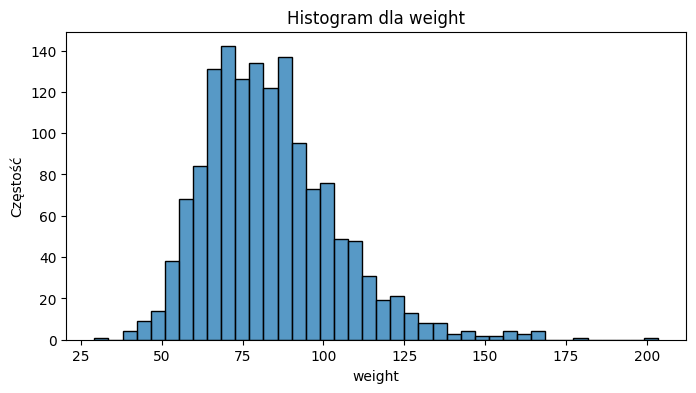

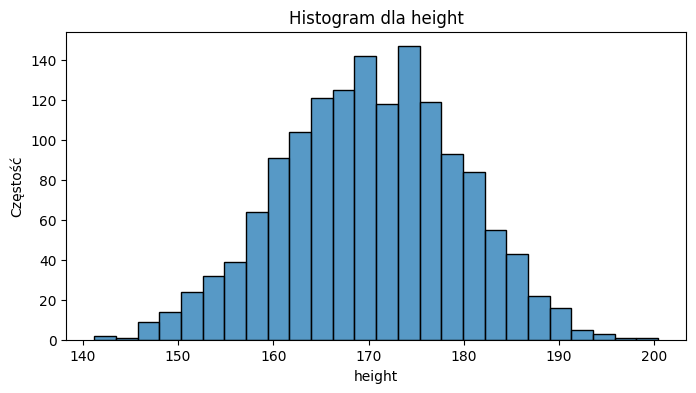

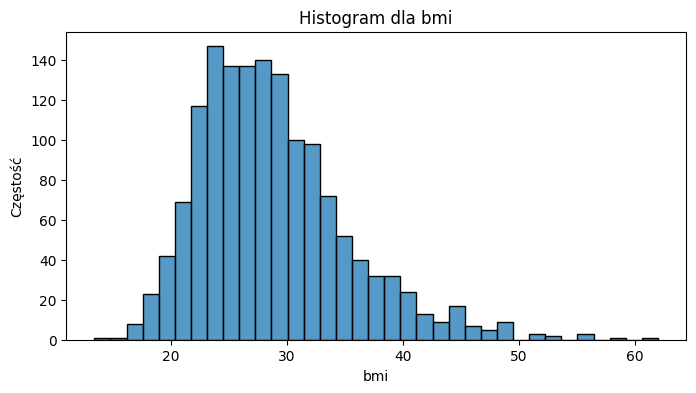

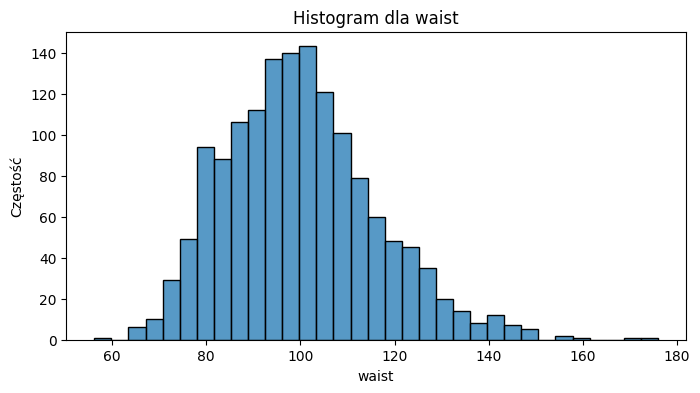

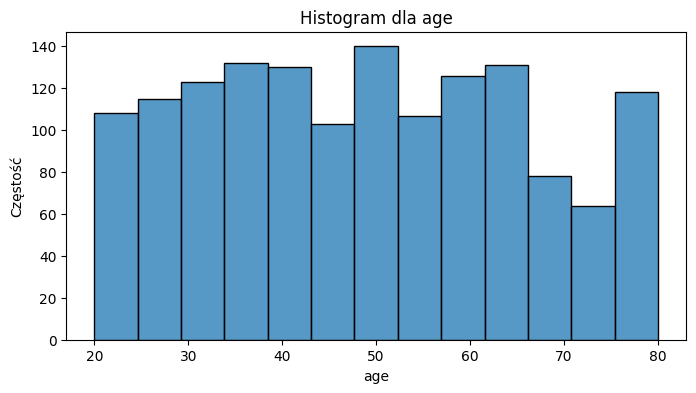

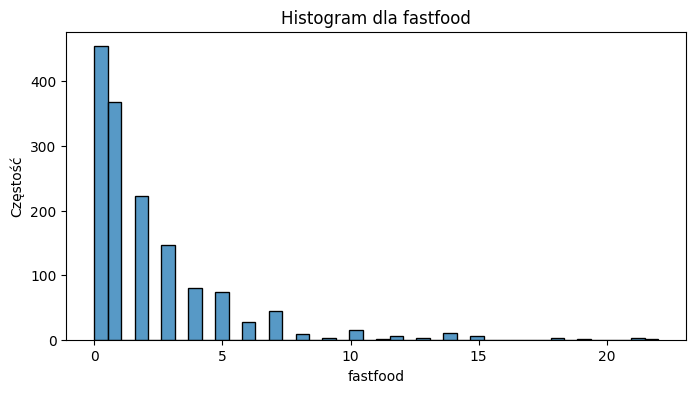

In [4]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col]) # type: ignore
    plt.title(f"Histogram dla {col}")
    plt.xlabel(col)
    plt.ylabel("Częstość")
    plt.show()


Histogramy:
- Systolic, Weight, Height, BMI oraz Waist: wyglądają na rozkłady normalne
- Age: relatywnie równa dystrybucja - pacjenci w różnym wieku
- Fast Food - większość pacjentów rzadko spożywa fasd food, lecz są osoby daleko na prawo

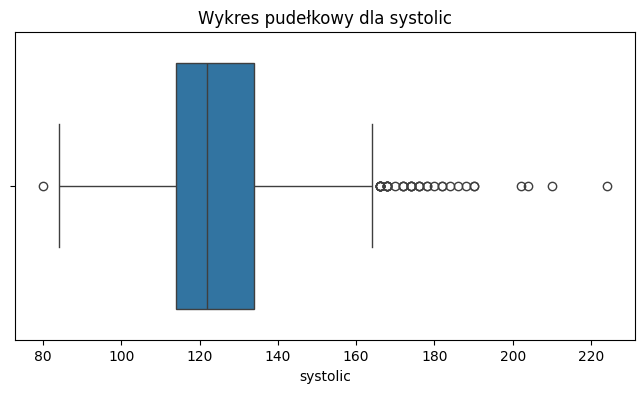

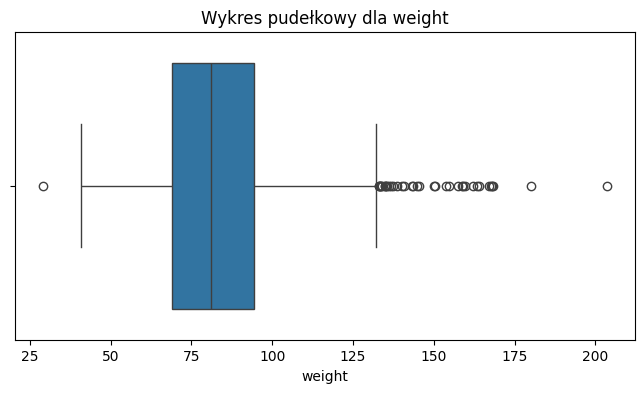

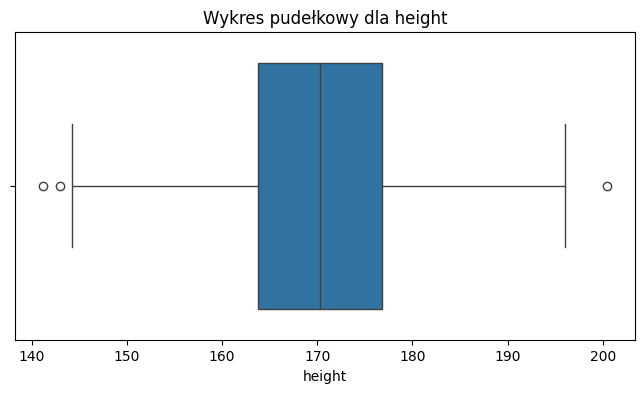

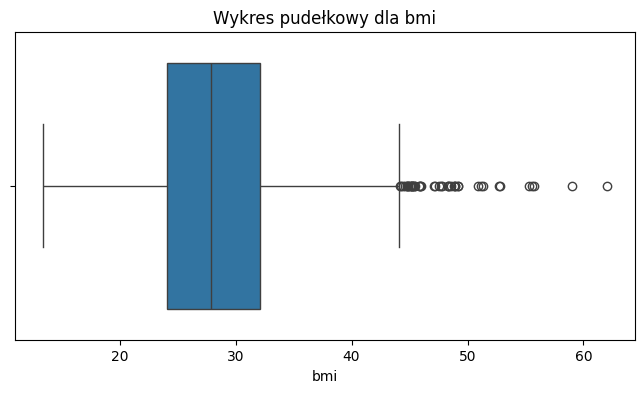

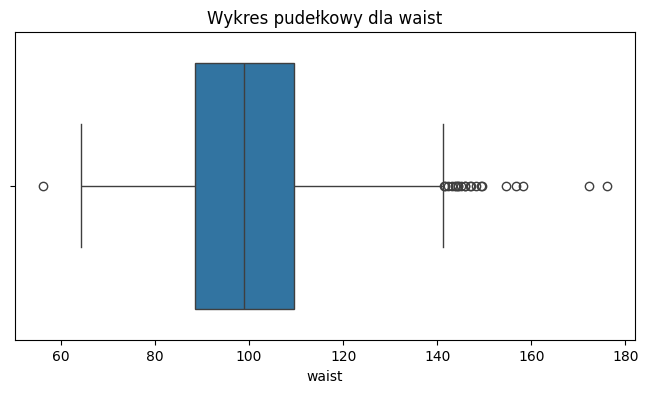

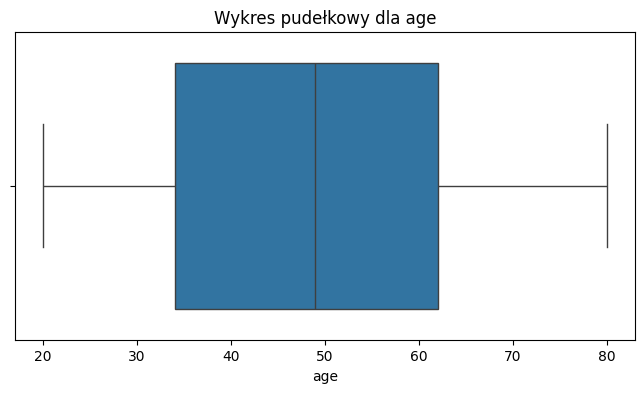

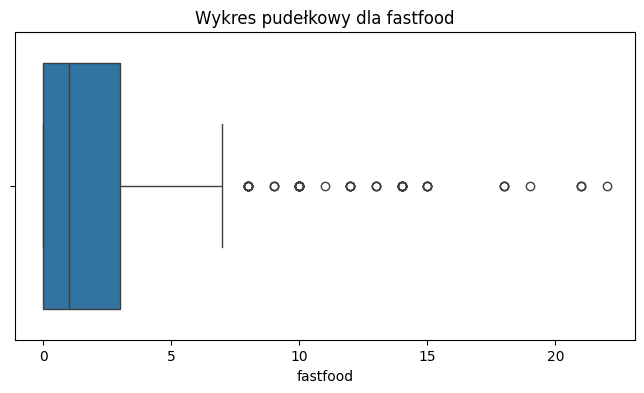

In [5]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Wykres pudełkowy dla {col}")
    plt.show()

In [6]:
statistics = pd.DataFrame({
    'Średnia': df[numeric_cols].mean(),
    'Mediana': df[numeric_cols].median(),
    'Odchylenie standardowe': df[numeric_cols].std()
})

display(statistics)

,Średnia,Mediana,Odchylenie standardowe
systolic,124.729492,122.0,17.620588
weight,83.563186,81.0,20.582301
height,170.179932,170.3,9.326330
bmi,28.793966,27.9,6.470551
waist,100.034508,98.9,16.153663
age,48.886780,49.0,16.975321
fastfood,2.139661,1.0,2.872604


### Wnioski
- ciśnienie średnie 124, lecz odchylenie standardowe sugeruje że część grupy może mieć nadciścnienie
- większość grupy je mało fastfoodów (mediana = 1), lecz średnia i duże odchylenie wskazują na nielicznych częstych konsumentów, którzy mogą wpływać na średnią.
- Duże odchylenia standardowe dla weight, waist, age i fastfood sugerują zróżnicowanie grupy

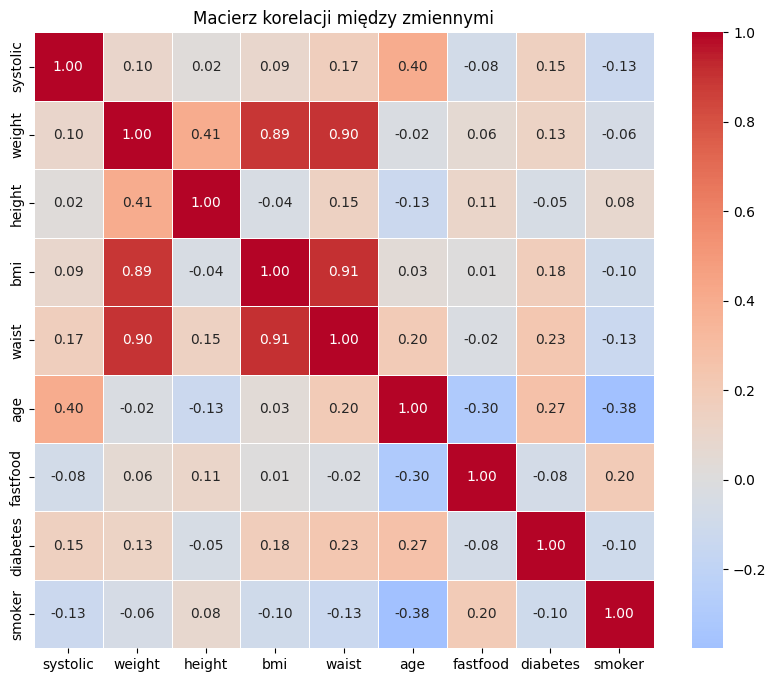

In [ ]:
# for method in ['pearson', 'kendall', 'spearman']:

corr_matrix = df[all_cols].corr(method='pearson') 

# print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=.5
)
plt.title(f"Macierz korelacji między zmiennymi")
plt.show()

## Analiza Korelacji

#### Skurczowe ciśnienie krwi
 - Największa korelacja z wiekiem
 - Lekka korelacja z palaczami, cukrzykami oraz z obwodem pasa
 - Słaba korelacja lub jej brak z innymi zmiennymi 

#### Inne
 - Silna korelacja między Wysokością, Obwódem w pasie, wysokością oraz BMI
 - Średnia korelacja między wiekiem, cukrzykami i palaczami
 - Lekka korelacja między wiekiem a szerokością pasa
 - Lekka korelacja między spożywaniem fast foodów oraz paleniem

## Wybór Modeli

### 1. Wiek

Wiek miał największy współczynnik korelacji, więc zbadamy czy ma wpływ na ciśnienie.

**Hipoteza Zerowa**

Wiek nie ma wpływu na ciśnienie

### 2. Palacze oraz cukrzycy

Obie zmienne miały lekką korelację z ciśnieniem

**Hipoteza Zerowa**

Palenie oraz cukrzyca nie wpływa na ciśnienie

### 3. Obwód Pasa, BMI oraz fast food

Obie zmienne miały lekką korelację z ciśnieniem

**Hipoteza Zerowa**

Dieta nie ma wpływu na ciśnienie

In [8]:
# Przygotowanie danych (dodanie stałej dla wyrazu wolnego)
df['intercept'] = 1

# 1. Model: systolic ~ age
model1 = ols('systolic ~ age', data=df).fit()

# 2. Model: systolic ~ smoker + diabetes
model2 = ols('systolic ~ smoker + diabetes', data=df).fit()

# 3. Model: systolic ~ waist + fastfood + bmi
model3 = ols('systolic ~ waist + fastfood + bmi', data=df).fit()

# Porównanie Adjusted R²
results = pd.DataFrame({
    'Model': [
        'systolic ~ age',
        'systolic ~ smoker + diabetes',
        'systolic ~ waist + fastfood + bmi'
    ],
    'R^2': [model1.rsquared, model2.rsquared, model3.rsquared],
    'Adjusted R^2': [model1.rsquared_adj, model2.rsquared_adj, model3.rsquared_adj],
    "p-value (F-statistic)": [model1.f_pvalue, model2.f_pvalue, model3.f_pvalue]
})

display(results)

# print(model1.summary())


,Model,R^2,Adjusted R^2,p-value (F-statistic)
0,systolic ~ age,0.161370,0.160801,2.641510e-58
1,systolic ~ smoker + diabetes,0.035868,0.034558,2.111308e-12
2,systolic ~ waist + fastfood + bmi,0.056737,0.054814,1.621872e-18


## Interpretacja

### Model 1 (systolic ~ age):

Adjusted R² = 0.1608: Wyjaśnia ~16% zmienności.

### Model 2 (systolic ~ smoker + diabetes):

Adjusted R² = 0.0346: Wyjaśnia tylko ~3.5% zmienności.

### Model 3 (systolic ~ waist + fastfood + bmi):

Adjusted R² = 0.0567: Trochę lepsze dopasowanie niż Model 2 - ponad 5%.

---
Wszystkie modele są raczej słabe (najlepszy wyjaśnia tylko 16%). Sugeruje to, 
że inne czynniki (nie zawarte w danych) mają większy wpływ.

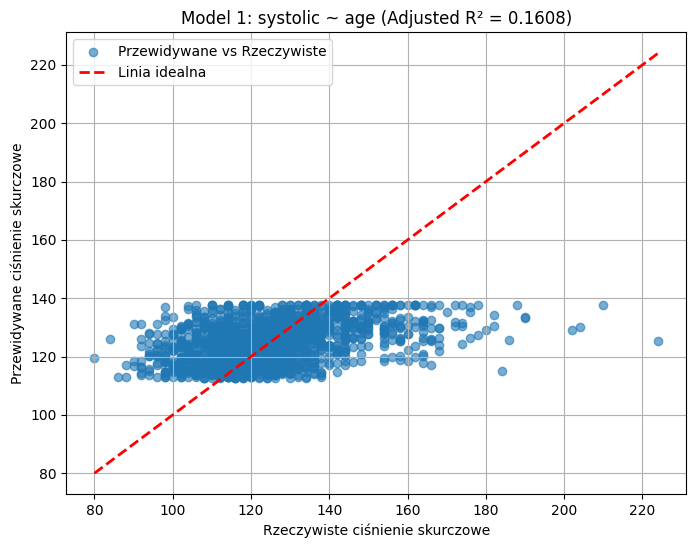

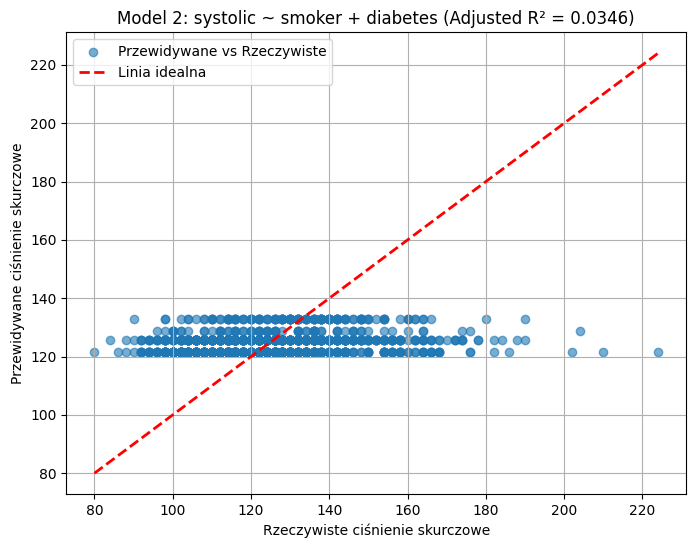

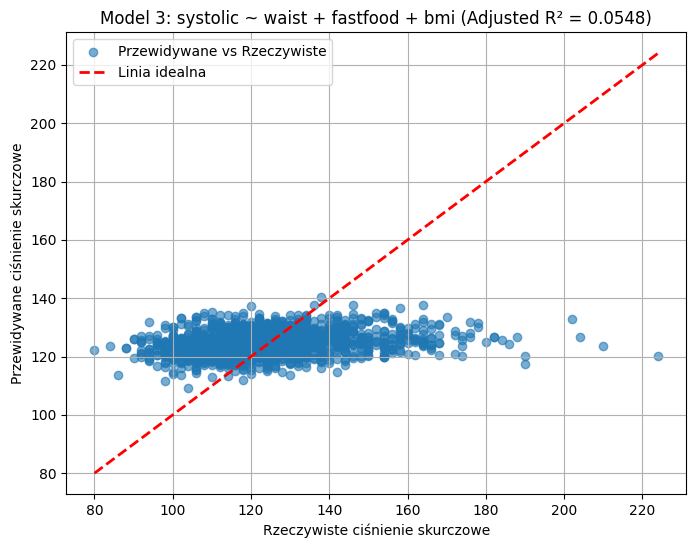

In [9]:
def plot_model_fit(model, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(df['systolic'], model.fittedvalues, alpha=0.6, label='Przewidywane vs Rzeczywiste')
    plt.plot([df['systolic'].min(), df['systolic'].max()],
             [df['systolic'].min(), df['systolic'].max()],
             'r--', lw=2, label='Linia idealna')
    plt.xlabel('Rzeczywiste ciśnienie skurczowe')
    plt.ylabel('Przewidywane ciśnienie skurczowe')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Wykres dla Modelu 1: systolic ~ age
plot_model_fit(model1, 'Model 1: systolic ~ age (Adjusted R² = {:.4f})'.format(model1.rsquared_adj))

# Wykres dla Modelu 2: systolic ~ smoker + diabetes
plot_model_fit(model2, 'Model 2: systolic ~ smoker + diabetes (Adjusted R² = {:.4f})'.format(model2.rsquared_adj))

# Wykres dla Modelu 3: systolic ~ waist + fastfood
plot_model_fit(model3, 'Model 3: systolic ~ waist + fastfood + bmi (Adjusted R² = {:.4f})'.format(model3.rsquared_adj))


In [10]:
# plt.scatter(model1.fittedvalues, model1.resid)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Przewidywane wartości')
# plt.ylabel('Reszty')
# plt.title('Wykres reszt dla Modelu 1')
# plt.show()

In [ ]:
def formula(model, params):
    wz = " systolic = {:.2f}".format(model.params["Intercept"])
    for param in params:
        wz += " + {:.2f} * {:s}".format(model.params[param], param)
    return wz

print(formula(model1, ["age"]))
print(formula(model2, ["smoker", "diabetes"]))
print(formula(model3, ["waist", "fastfood", "bmi"]))

 systolic = 104.34 + 0.42 * age
 systolic = 125.58 + -3.92 * smoker + 7.18 * diabetes
 systolic = 99.77 + 0.54 * waist + -0.43 * fastfood + -0.99 * bmi


## Wzory

| model | wzór |
| --- | --- |
systolic ~ age |systolic = 104.34 + 0.42 * age
systolic ~ smoker + diabetes | systolic = 125.58 - 3.92 * smoker + 7.18 * diabetes
systolic ~ waist + fastfood + bmi | systolic = 99.77 + 0.54 * waist - 0.43 * fastfood - 0.99 * bmi



In [19]:
print(model1.summary())
print(model2.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               systolic   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     283.4
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           2.64e-58
Time:                        21:32:04   Log-Likelihood:                -6194.5
No. Observations:                1475   AIC:                         1.239e+04
Df Residuals:                    1473   BIC:                         1.240e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.3447      1.282     81.412      0.0

## Istotność współczynników

Dla każdego współczynnika p-wartość (kolumna `P>|t|`) jest bliska zeru, co oznacza, że wszystkie współczynniki są statystycznie istotne. Innymi słowy, możemy odrzucić hipotezy zerowe o braku wpływu tych zmiennych na ciśnienie.

## Interpretacje współczynników

### Model 1

- Wyraz wolny - 104.34 - Można interpretować jako przewidywane ciśninie dla osoby w wieku 0 wynopsi 104
- Współczynnik dla wieku - 0.42 - Oznacza, że każdy dodatkowy rok życia wiąże się ze wzrostem ciśnienia skurczowego o 0.42 mmHg, przy założeniu, że inne czynniki pozostają stałe.

## Model 2

- Wyraz wolny - 125.58 - przewidywane ciśnienie skurczowe dla osoby niepalącej bez cukrzycy
- Współczynnik dla palaczy - -3.92 - Osoby palące mają niższe ciśnienie o 3.92 - jest to dość dziwny wynik, bo konwencjonalna wiedza sugerowałaby odwrotną zależność. Możliwe że inne zmienne tu grają rolę, lub jest mała próbka palaczy.
- Współczynnik dla 7.18 - Osoby z cukrzycą mają wyższe ciśnienie

In [23]:
# # Obliczenie średniej i odchylenia standardowego dla 'systolic'
# mean_systolic = df['systolic'].mean()
# std_systolic = df['systolic'].std()

# # Obliczenie współczynnika zmienności
# V_systolic = std_systolic / mean_systolic

# print(f"Średnia ciśnienia skurczowego: {mean_systolic:.2f} mmHg")
# print(f"Odchylenie standardowe: {std_systolic:.2f} mmHg")
# print(f"Współczynnik zmienności (V): {V_systolic:.4f} (lub {V_systolic*100:.2f}%)")

# # Podział danych na palaczy i niepalących
# smokers = df[df['smoker'] == 1]['systolic']
# non_smokers = df[df['smoker'] == 0]['systolic']

# # Obliczenie V dla obu grup
# V_smokers = np.std(smokers) / np.mean(smokers)
# V_non_smokers = np.std(non_smokers) / np.mean(non_smokers)

# print(f"Współczynnik zmienności dla palaczy: {V_smokers:.4f} ({V_smokers*100:.2f}%)")
# print(f"Współczynnik zmienności dla niepalących: {V_non_smokers:.4f} ({V_non_smokers*100:.2f}%)")

## Interpretacja współczynnika zmienności



Test Shapiro-Wilka: statystyka=0.9675, p-wartość=0.0000


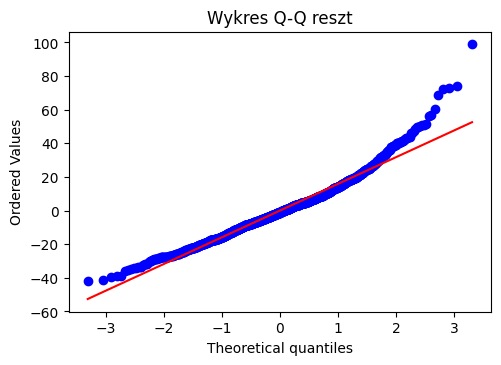

In [15]:
residuals = model1.resid

# Normalność reszt
# Wykres Q-Q
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
scipy.stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Wykres Q-Q reszt")


# Test Shapiro-Wilka
# print(len(residuals))
shapiro_stat, shapiro_p = scipy.stats.shapiro(residuals)
print(f"Test Shapiro-Wilka: statystyka={shapiro_stat:.4f}, p-wartość={shapiro_p:.4f}")


## Normalność reszt

Na wykresie kwantyl-kwantyl widać kilka odstających wartości w prawej górnej części. Poza tymi wartościami dane dobrze pasują do modelu. 

P-wartość testu Shapiro-Wilka jest bliska zeru więc możemy odrzucić hipotezę zerową o normalności rozkładu - reszty nie mają normalnego rozkładu.

In [16]:
# Test na zerową wartość średniej reszt
t_stat, t_p = scipy.stats.ttest_1samp(model1.resid, 0)
print(f"\nTest t-Studenta dla średniej reszt: statystyka={t_stat:.4f}, p-wartość={t_p:.4f}")



Test t-Studenta dla średniej reszt: statystyka=0.0000, p-wartość=1.0000


## Test na zerową wartość średniej

P-wartość testu t-studenta jest bliska 1, więc możemy nie odrzucać hipotezę zerową "Średnia reszt jest równa 0". Średnia reszt nie różni się istotnie od 0


Test Breuscha-Pagana: statystyka=26.4844, p-wartość=0.0000


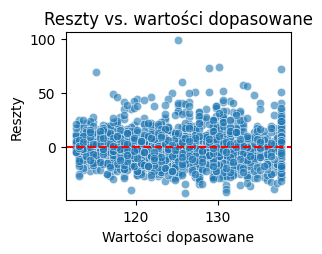

In [17]:
# Homoskedastyczność
# Wykres reszt vs. wartości dopasowane
plt.subplot(2, 2, 2)
sns.scatterplot(x=model1.fittedvalues, y=model1.resid, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Reszty vs. wartości dopasowane")
plt.xlabel("Wartości dopasowane")
plt.ylabel("Reszty")

# Test Breuscha-Pagana
bp_stat, bp_p, _, _ = sm.stats.diagnostic.het_breuschpagan(model1.resid, model1.model.exog)
print(f"\nTest Breuscha-Pagana: statystyka={bp_stat:.4f}, p-wartość={bp_p:.4f}")



## Homoskedastyczność

Hipoteza zerowa: Homoskedastyczność (stała wariancja reszt). P-wartość jest bliska zeru więc obserwujemy heteroskedastyczność


Test Durbina-Watsona: 2.0475


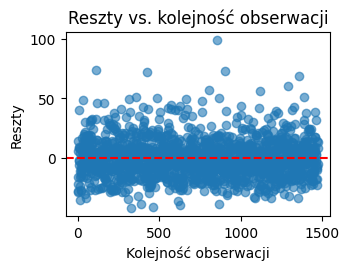

In [18]:
# Autokorelacja
# Test Durbina-Watsona
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print(f"\nTest Durbina-Watsona: {dw_stat:.4f}")

# Wykres reszt vs. kolejność obserwacji
plt.subplot(2, 2, 3)
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Reszty vs. kolejność obserwacji")
plt.xlabel("Kolejność obserwacji")
plt.ylabel("Reszty")

plt.tight_layout()
plt.show()

## Autokorelacja

Test Durbina-Watsona daje nam wartość bliską 2, więc jest brak autokorelacji


## Ograniczenia analizy

1. **Niskie R²** - modele wyjaśniają max 16% zmienności
2. **Brak normalności reszt** - narusza założenia MNK
3. **Heteroskedastyczność** - wymaga robust standard errors
5. **Małe próby** - tylko 1000 obserwacji